In [1]:
#Imports

import numpy as np
import matplotlib.pyplot as plt
import hera_cal.abscal as abscal
import uvtools.dspec as dspec 
import hera_pspec
from hera_pspec import pspecbeam
from hera_pspec import pspecdata
import itertools
import scipy 
from scipy import signal
import pickle
import copy
from hera_cal.utils import polnum2str, polstr2num, jnum2str, jstr2num
from hera_cal.io import HERAData, HERACal
from hera_cal.io import DataContainer 
from hera_cal import apply_cal
from hera_cal import io
from hera_cal import smooth_cal
from hera_cal import vis_clean
from hera_cal import redcal
from pyuvdata import UVFlag
import glob
import tqdm
import os
import shutil
from hera_cal import frf
import imp
from hera_pspec import utils as uvp_utils
from hera_pspec import plot as pspec_plot
from hera_pspec import grouping

/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next maj

In [2]:
%config Completer.use_jedi = False

In [3]:
#Scale Plot/Figure Sizes

plt.rcParams['figure.figsize'] = 20,10
plt.rcParams['font.size'] = 20

In [4]:
#Discrete Fourier Transform 

def fft(x):
    bh = dspec.gen_window('bh', (x.shape[1]))
    return np.abs(np.fft.fftshift(np.fft.fft(np.fft.fftshift(bh*x))))

In [8]:
file_before_10 = 'HERA_CLEAN_NOPRISIM_averagebeforefilter/data_avg_avg_beforefiltered.Cavg.uvh5'
file_after_10 = 'HERA_CLEAN_NOPRISIM_averageafterfilter/data_avg_avg_afterfiltered.Cavg.uvh5'
file_before_8 = 'HERA_CLEAN_NOPRISIM_FULL_averagebeforefilter/data_avg_avg_beforefiltered.Cavg.uvh5'
file_after_8 = 'HERA_CLEAN_NOPRISIM_FULL_averageafterfilter/data_avg_avg_afterfiltered.Cavg.uvh5'

avg_before_filter_10 = HERAData(file_before_10)
avg_after_filter_10 = HERAData(file_after_10)
avg_before_filter_8 = HERAData(file_before_8)
avg_after_filter_8 = HERAData(file_after_8)

avg_bf_data_10, avg_bf_flags_10,avg_bf_nsamples_10 = avg_before_filter_10.read()
avg_af_data_10, avg_af_flags_10,avg_af_nsamples_10 = avg_after_filter_10.read()
avg_bf_data_8, avg_bf_flags_8,avg_bf_nsamples_8 = avg_before_filter_8.read()
avg_af_data_8, avg_af_flags_8,avg_af_nsamples_8 = avg_after_filter_8.read()

lambd = 3e+8 / 150e+6 
fwhm = (2.44*lambd)/14
airy_beam = pspecbeam.PSpecBeamGauss(fwhm,avg_after_filter_10.freqs)


Telescope RIMEz calculation is not in known_telescopes.
LST values stored in HERA_CLEAN_NOPRISIM_averagebeforefilter/data_avg_avg_beforefiltered.Cavg.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in HERA_CLEAN_NOPRISIM_averageafterfilter/data_avg_avg_afterfiltered.Cavg.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in HERA_CLEAN_NOPRISIM_FULL_averagebeforefilter/data_avg_avg_beforefiltered.Cavg.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
LST values stored in HERA_CLEAN_NOPRISIM_FULL_averageafterfilter/data_avg_avg_afterfiltered.Cavg.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
Telescope RIMEz calculation is not in known_telescopes.
LST values stored in HERA_CLEA

In [10]:
selection = (avg_before_filter_10.lsts*(24/(2*np.pi)) >= 4.2) & (avg_before_filter_10.lsts*(24/(2*np.pi)) <= 6.2)

In [11]:
avg_before_filter_10.select(times = avg_before_filter_10.times[selection])
avg_after_filter_10.select(times = avg_after_filter_10.times[selection])

In [12]:
avg_before_filter_8.select(times = avg_before_filter_8.times[selection])
avg_after_filter_8.select(times = avg_after_filter_8.times[selection])

In [13]:
data_avg_before = DataContainer({})
flags_avg_before = DataContainer({})
nsamples_avg_before = DataContainer({})
for bl in avg_bf_data_10:
    data_avg_before[bl] = (avg_bf_data_10[bl]*avg_bf_nsamples_10[bl]*(~avg_bf_flags_10[bl])) + (avg_bf_data_8[bl]*avg_bf_nsamples_8[bl]*(~avg_bf_flags_8[bl]))
    flags_avg_before[bl] = avg_bf_flags_10[bl] & avg_bf_flags_8[bl]
    nsamples_avg_before[bl] = (avg_bf_nsamples_10[bl]*(~avg_bf_flags_10[bl])) + (avg_bf_nsamples_8[bl]*(~avg_bf_flags_8[bl]))
    data_avg_before[bl] = data_avg_before[bl]/nsamples_avg_before[bl]
    data_avg_before[bl][~np.isfinite(data_avg_before[bl])] = 0.0

invalid value encountered in true_divide


In [14]:
data_avg_after = DataContainer({})
flags_avg_after = DataContainer({})
nsamples_avg_after = DataContainer({})
for bl in avg_af_data_10:
    data_avg_after[bl] = (avg_af_data_10[bl]*avg_af_nsamples_10[bl]*(~avg_af_flags_10[bl])) + (avg_af_data_8[bl]*avg_af_nsamples_8[bl]*(~avg_af_flags_8[bl]))
    flags_avg_after[bl] = avg_af_flags_10[bl] & avg_af_flags_8[bl]
    nsamples_avg_after[bl] = (avg_af_nsamples_10[bl]*(~avg_af_flags_10[bl])) + (avg_af_nsamples_8[bl]*(~avg_af_flags_8[bl]))
    data_avg_after[bl] = data_avg_after[bl]/nsamples_avg_after[bl]
    data_avg_after[bl][~np.isfinite(data_avg_after[bl])] = 0.0

invalid value encountered in true_divide


In [16]:
hd_before = HERAData(file_before_10)
data,flags,nsamples = hd_before.read()
hd_before.update(data=data_avg_before, flags=flags_avg_before, nsamples=nsamples_avg_before)
hd_before.write_uvh5('data_avg_before.uvh5', clobber=True)

hd_before = HERAData('data_avg_before.uvh5')
data_avg_before, flags_avg_before, nsamples_avg_before = hd_before.read()

File exists; clobbering


Telescope RIMEz calculation is not in known_telescopes.
LST values stored in data_avg_before.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


In [17]:
hd_after = HERAData(file_after_10)
data,flags,nsamples = hd_after.read()
hd_after.update(data=data_avg_after, flags=flags_avg_after, nsamples=nsamples_avg_after)
hd_after.write_uvh5('data_avg_after.uvh5', clobber=True)

hd_after = HERAData('data_avg_after.uvh5')
data_avg_after, flags_avg_after, nsamples_avg_after = hd_after.read()

Telescope RIMEz calculation is not in known_telescopes.
LST values stored in HERA_CLEAN_NOPRISIM_averageafterfilter/data_avg_avg_afterfiltered.Cavg.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.
Telescope RIMEz calculation is not in known_telescopes.
LST values stored in data_avg_after.uvh5 are not self-consistent with time_array and telescope location. Consider recomputing with utils.get_lst_for_time.


In [11]:
# file = '/lustre/aoc/projects/hera/aewallwi/time_dep_flagging/2458098/zen.2458098.26719.foregrounds.true.uvh5'
# dat = HERAData(file)
# data, flags, nsamples = dat.read()
# jul = 24*3600
# bh = dspec.gen_window('bh4',1024)
# interpolated_times = (data.times - data.times.min())*jul
# delay_blh = np.fft.fftshift(np.fft.fftfreq(len(bh),data.freqs[1] - data.freqs[0]))
# ext = (delay_blh.min()*1e+9, delay_blh.max()*1e+9, interpolated_times.max(), interpolated_times.min())
# plt.imshow(np.log10(np.abs(fft(bh*(data[(11, 14, 'nn')]*(data.freqs[1]-data.freqs[0]))))), extent=ext, aspect='auto')
# clb = plt.colorbar()
# clb.ax.set_title('[Jy*Hz]')
# plt.title('Original Simulation (1/32)')
# plt.xlabel('Delay [ns]')
# plt.ylabel('Simulation Time [s]')

In [12]:
# jul = 24*3600
# bh = dspec.gen_window('bh',614)
# interpolated_times = (avg_bf_data.times - avg_bf_data.times.min())*jul
# delay_blh = np.fft.fftshift(np.fft.fftfreq(len(bh),avg_bf_data.freqs[1] - avg_bf_data.freqs[0]))
# ext = (delay_blh.min()*1e+9, delay_blh.max()*1e+9, interpolated_times.max(), interpolated_times.min())
# plt.imshow(np.log10(np.abs(fft(bh*(avg_bf_data[(11, 14, 'nn')]*(avg_bf_data.freqs[1]-avg_bf_data.freqs[0]))))), extent=ext, aspect='auto')
# clb = plt.colorbar()
# clb.ax.set_title('[Jy*Hz]')
# plt.title('Average Before Fourier-Filter')
# plt.xlabel('Delay [ns]')
# plt.ylabel('Simulation Time [s]')

In [13]:
# jul = 24*3600
# bh = dspec.gen_window('bh',614)
# interpolated_times = (avg_af_data.times - avg_af_data.times.min())*jul
# delay_blh = np.fft.fftshift(np.fft.fftfreq(len(bh),avg_af_data.freqs[1] - avg_af_data.freqs[0]))
# ext = (delay_blh.min()*1e+9, delay_blh.max()*1e+9, interpolated_times.max(), interpolated_times.min())
# plt.imshow(np.log10(np.abs(fft(bh*(avg_af_data[(11, 14, 'nn')]*(avg_af_data.freqs[1]-avg_af_data.freqs[0]))))), extent=ext, aspect='auto')
# clb = plt.colorbar()
# clb.ax.set_title('[Jy*Hz]')
# plt.title('Average After Fourier-Filter')
# plt.xlabel('Delay [ns]')
# plt.ylabel('Simulation Time [s]')

In [31]:
from hera_pspec import utils as uvp_utils
bls1, bls2, _, _, _, red_groups_lim, red_lens, _ = uvp_utils.calc_blpair_reds(avg_before_filter_10,avg_after_filter_10,
                                                                          exclude_auto_bls=True,extra_info=True,
                                                                          bl_len_range=(14,45))


red_antpairs_lim = [[] for m in range(np.max(red_groups_lim)+1)]
for group,bl1,bl2 in zip(red_groups_lim,bls1,bls2):
    red_antpairs_lim[group].append((bl1,bl2))   

In [32]:
from hera_pspec import utils as uvp_utils
bls3, bls4, _, _, _, red_groups, red_lens, _ = uvp_utils.calc_blpair_reds(avg_before_filter_10,avg_after_filter_10,
                                                                          exclude_auto_bls=True,extra_info=True)


red_antpairs = [[] for m in range(np.max(red_groups)+1)]
for group,bl3,bl4 in zip(red_groups,bls3,bls4):
    red_antpairs[group].append((bl3,bl4))  

In [20]:
psd_before = pspecdata.PSpecData(dsets=[hd_before], beam=airy_beam)
psd_before.Jy_to_mK()
psd_before.broadcast_dset_flags(spw_ranges=[(357,562), (20,184)])

psd_after = pspecdata.PSpecData(dsets=[hd_after], beam=airy_beam)
psd_after.Jy_to_mK()
psd_after.broadcast_dset_flags(spw_ranges=[(357,562), (20,184)])

In [33]:
red_antpairs = [x for x in red_antpairs if x != []]
red_antpairs_lim = [x for x in red_antpairs_lim if x != []]

In [5]:
uvp_before = psd_before.pspec(bls1=bls3,
                              bls2=bls4,
                              taper='bh7', dsets=[0,0],pols=('yy','yy'),
                              sampling=True,store_window=False,
                              spw_ranges=[(357,562), (20,184)], allow_fft=True)

uvp_before.average_spectra(time_avg=True,blpair_groups=red_antpairs)

In [6]:
uvp_after = psd_after.pspec(bls1=bls3,
                              bls2=bls4,
                              taper='bh7', dsets=[0,0],pols=('yy','yy'),
                              sampling=True,store_window=False,
                              spw_ranges=[(357,562), (20,184)], allow_fft=True)

uvp_after.average_spectra(time_avg=True,blpair_groups=red_antpairs)

In [7]:
uvp_before_lim = psd_before.pspec(bls1=bls1,
                              bls2=bls2,
                              taper='bh7', dsets=[0,0],pols=('yy','yy'),
                              sampling=True,store_window=False,
                              spw_ranges=[(357,562), (20,184)], allow_fft=True)

uvp_before_lim.average_spectra(time_avg=True,blpair_groups=red_antpairs_lim)

In [8]:
uvp_after_lim = psd_after.pspec(bls1=bls1,
                              bls2=bls2,
                              taper='bh7', dsets=[0,0],pols=('yy','yy'),
                              sampling=True,store_window=False,
                              spw_ranges=[(357,562), (20,184)], allow_fft=True)

uvp_after_lim.average_spectra(time_avg=True,blpair_groups=red_antpairs_lim)

In [ ]:
# uvp_after.get_blpairs()

In [ ]:
# plt.imshow(np.log10(uvp_before.get_data((0,((0,11),(1,12)),('yy','yy'))).real), aspect='auto', vmin=1, vmax=11)
# plt.colorbar()
# plt.figure()
# plt.imshow(np.log10(uvp_after.get_data((0,((0,11),(1,12)),('yy','yy'))).real), aspect='auto', vmin=1, vmax=11)
# plt.colorbar()

In [ ]:
# fig,axarray = plt.subplots(1,2)
# fig.set_size_inches(12,6)
# plt.sca(axarray[0])
# handle =pspec_plot.delay_wedge(uvp_before,spw=0,pol=('yy','yy'),fold=True,rotate=True, colorbar=True,
#                                vmin=1,vmax=11, ax=axarray[0], delay=False)
# plt.gca().set_ylim(0,1)
# plt.sca(axarray[1])
# handle = pspec_plot.delay_wedge(uvp_after,spw=0,pol=('yy','yy'),fold=True,rotate=True, colorbar=True,
#                                vmin=1,vmax=11, ax=axarray[1], delay=False)
# plt.gca().set_ylim(0,1)


In [36]:
k_data_before = uvp_before.get_kparas(0)[104::2]
k_bins_before = np.diff(k_data_before)

k_data_after = uvp_after.get_kparas(0)[104::2]
k_bins_after= np.diff(k_data_after)
#print(np.any(np.isnan(uvp_after.data_array[0])))

k_data_before_lim = uvp_before_lim.get_kparas(0)[104::2]
k_bins_before_lim = np.diff(k_data_before_lim)

k_data_after_lim = uvp_after_lim.get_kparas(0)[104::2]
k_bins_after_lim = np.diff(k_data_after_lim)


uvp_before_sph = grouping.spherical_average(uvp_in=uvp_before,kbins=k_data_before[:-1], bin_widths=k_bins_before)
uvp_after_sph = grouping.spherical_average(uvp_in=uvp_after,kbins=k_data_after[:-1], bin_widths=k_bins_after)
uvp_before_sph_lim = grouping.spherical_average(uvp_in=uvp_before_lim,kbins=k_data_before_lim[:-1], bin_widths=k_bins_before_lim)
uvp_after_sph_lim = grouping.spherical_average(uvp_in=uvp_after_lim,kbins=k_data_after_lim[:-1], bin_widths=k_bins_after_lim)

#print(uvp_after_sph.get_blpairs())
#print(uvp_after_sph.get_data((0, ((0, 15), (1, 16)), ('xx', 'xx')))[0])


Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


Text(0.5, 0, '$k$ [$hMpc^{-1}$]')

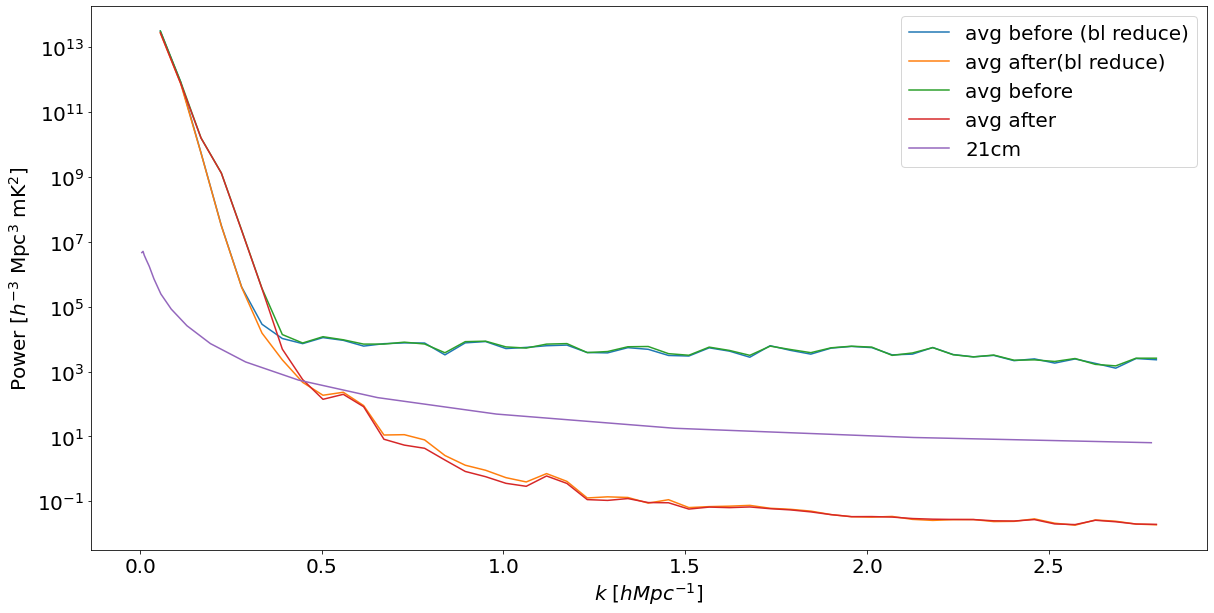

In [38]:
file = 'ps_no_halos_z008.46_nf0.581596_useTs1_NX2.0e-01_alphaX1.5_TvirminX2.0e+05_aveTb001 (1).53_Pop2_1024_1600Mpc_v3'
delta_21 = np.loadtxt(file, usecols=1)
k = np.loadtxt(file,usecols=0)

plt.plot(k_data_before_lim[:-1], uvp_before_sph_lim.get_data((0, ((0, 11), (1, 12)), ('yy', 'yy')))[0], label='avg before (bl reduce)')
plt.plot(k_data_after_lim[:-1], uvp_after_sph_lim.get_data((0, ((0, 11), (1, 12)), ('yy', 'yy')))[0],label='avg after(bl reduce)')
plt.plot(k_data_before[:-1], uvp_before_sph.get_data((0, ((0, 11), (1, 12)), ('yy', 'yy')))[0], label='avg before')
plt.plot(k_data_after[:-1], uvp_after_sph.get_data((0, ((0, 11), (1, 12)), ('yy', 'yy')))[0],label='avg after')
plt.plot(k,(delta_21/k**3)*2*np.pi**2, label='21cm')
plt.yscale('log')
plt.legend()
plt.ylabel('Power [$h^{-3}$ Mpc$^3$ mK$^2$]')
plt.xlabel('$k$ [$hMpc^{-1}$]')